In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_data(filepath):
    texts = []
    labels = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                text, label = line.rsplit(';', 1)
                texts.append(text)
                labels.append(label)
    return pd.DataFrame({'text': texts, 'label': labels})

# Load datasets
train_data = load_data("/Users/parthnavadiya/Desktop/Exams/Deep Learning/archive/train.txt")
val_data = load_data("/Users/parthnavadiya/Desktop/Exams/Deep Learning/archive/val.txt")
test_data = load_data("/Users/parthnavadiya/Desktop/Exams/Deep Learning/archive/test.txt")

# Encode labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
val_data['label'] = label_encoder.transform(val_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

# Save classes for later use
emotion_classes = label_encoder.classes_
print("Emotion classes:", list(emotion_classes))


Emotion classes: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 50
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_data['text'])

# Convert text to padded sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text']), maxlen=max_len, padding='post')
x_val = pad_sequences(tokenizer.texts_to_sequences(val_data['text']), maxlen=max_len, padding='post')
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text']), maxlen=max_len, padding='post')

print("x_train shape:", x_train.shape)


x_train shape: (16000, 50)


In [10]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_data['label'])
y_val = to_categorical(val_data['label'])
y_test = to_categorical(test_data['label'])

print("y_train shape:", y_train.shape)


y_train shape: (16000, 6)


In [11]:
from sklearn.utils import class_weight
import numpy as np

# Convert one-hot back to class indices
y_train_labels = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.2351397251814111), 1: np.float64(1.3766993632765445), 2: np.float64(0.49732686808404825), 3: np.float64(2.044989775051125), 4: np.float64(0.5715102157451064), 5: np.float64(4.662004662004662)}


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(emotion_classes), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_emotion_model.h5', save_best_only=True)
]


In [14]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2333 - loss: 1.6642

500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.2337 - loss: 1.6635 - val_accuracy: 0.8780 - val_loss: 0.4100
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8939 - loss: 0.3386

500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8939 - loss: 0.3385 - val_accuracy: 0.9050 - val_loss: 0.2934
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9347 - loss: 0.1818 - val_accuracy: 0.9030 - val_loss: 0.3030
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9320 - loss: 0.1827 - val_accuracy: 0.9025 - val_loss: 0.3279
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9599 - loss: 0.1032 - val_accuracy: 0.8970 - val_loss: 0.3329


In [15]:
# Load best weights
model.load_weights('best_emotion_model.h5')

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8836 - loss: 0.3254
Test Loss: 0.3138
Test Accuracy: 0.8900


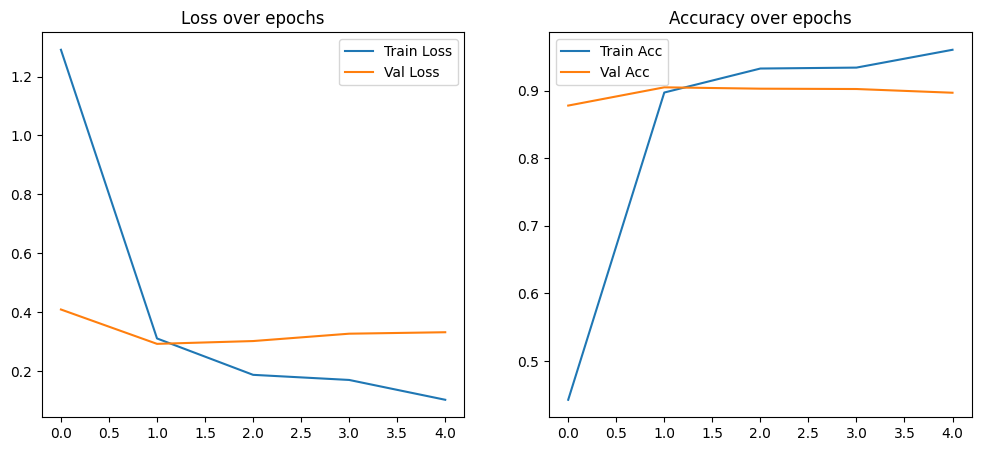

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       275
        fear       0.87      0.82      0.85       224
         joy       0.96      0.87      0.91       695
        love       0.68      0.94      0.79       159
     sadness       0.93      0.93      0.93       581
    surprise       0.62      0.92      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.90      0.89      0.89      2000



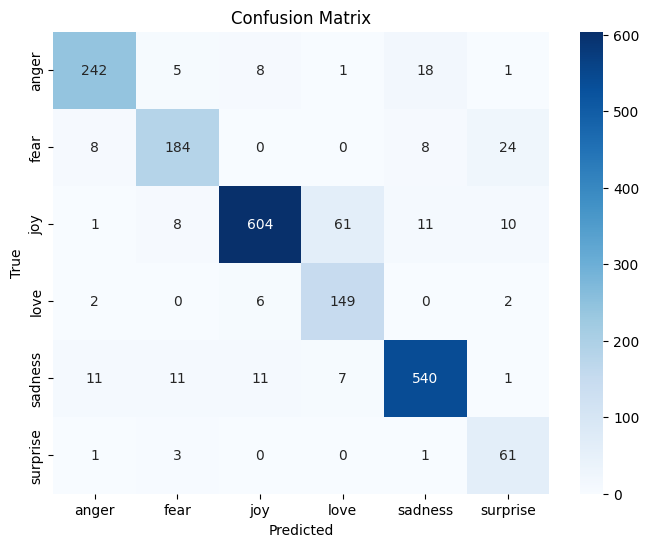

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_test_pred_probs = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print(classification_report(y_test_true, y_test_pred, target_names=emotion_classes))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import pickle

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model
model.save('emotion_detection_model.h5')


In [19]:
from tensorflow.keras.models import load_model
import pickle

model = load_model('emotion_detection_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


In [20]:
def predict_emotion(text, model, tokenizer, max_len=50):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred_prob = model.predict(padded)[0]
    pred_class = np.argmax(pred_prob)
    return emotion_classes[pred_class], pred_prob[pred_class]

# Example
text = "I am so happy today!"
emotion, confidence = predict_emotion(text, model, tokenizer)
print(f"Predicted emotion: {emotion} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted emotion: joy with confidence 0.62


In [21]:
examples = [
    "I am so sad and disappointed.",
    "This is amazing, I love it!",
    "I'm feeling anxious about tomorrow.",
    "The weather is okay, nothing special.",
    "Why does everything go wrong?"
]

for text in examples:
    emotion, confidence = predict_emotion(text, model, tokenizer)
    print(f"Text: {text}\nPredicted emotion: {emotion} (confidence: {confidence:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: I am so sad and disappointed.
Predicted emotion: sadness (confidence: 0.96)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: This is amazing, I love it!
Predicted emotion: surprise (confidence: 0.63)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: I'm feeling anxious about tomorrow.
Predicted emotion: fear (confidence: 0.95)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: The weather is okay, nothing special.
Predicted emotion: joy (confidence: 0.81)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: Why does everything go wrong?
Predicted emotion: sadness (confidence: 0.45)



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       275
        fear       0.87      0.82      0.85       224
         joy       0.96      0.87      0.91       695
        love       0.68      0.94      0.79       159
     sadness       0.93      0.93      0.93       581
    surprise       0.62      0.92      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.90      0.89      0.89      2000



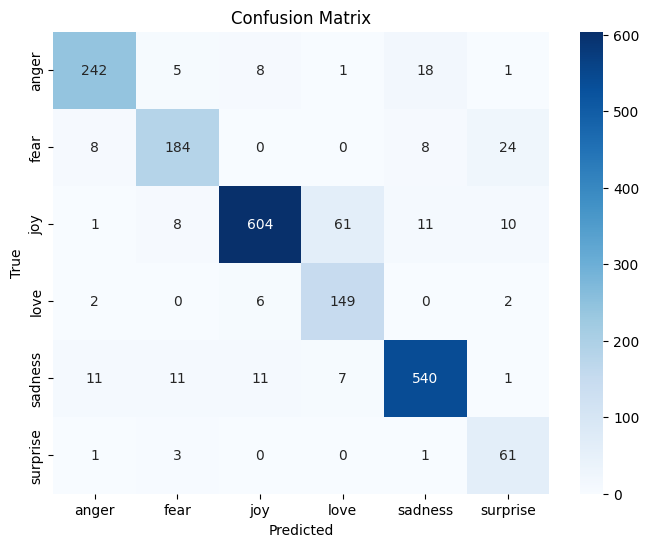

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=emotion_classes))

# Optional: confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [23]:
model.save("emotion_model.h5")

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities on test set
y_pred_prob = model.predict(x_test)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded test labels back to class indices
y_true = np.argmax(y_test, axis=1)

# Print detailed classification metrics
print(classification_report(y_true, y_pred, target_names=emotion_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       275
        fear       0.87      0.82      0.85       224
         joy       0.96      0.87      0.91       695
        love       0.68      0.94      0.79       159
     sadness       0.93      0.93      0.93       581
    surprise       0.62      0.92      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.90      0.89      0.89      2000



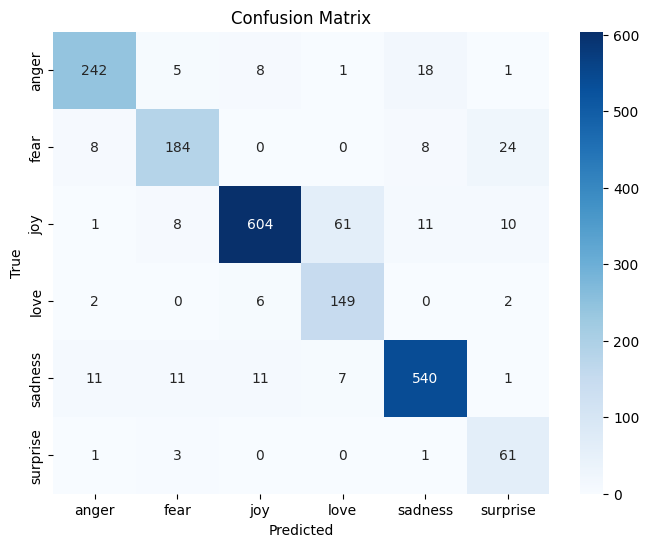

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8900


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
📊 Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       275
        fear       0.87      0.82      0.85       224
         joy       0.96      0.87      0.91       695
        love       0.68      0.94      0.79       159
     sadness       0.93      0.93      0.93       581
    surprise       0.62      0.92      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.90      0.89      0.89      2000



/var/folders/c1/xyrvb1rn0b1chvw99w0xcb6m0000gn/T/ipykernel_28203/510659225.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/parthnavadiya/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


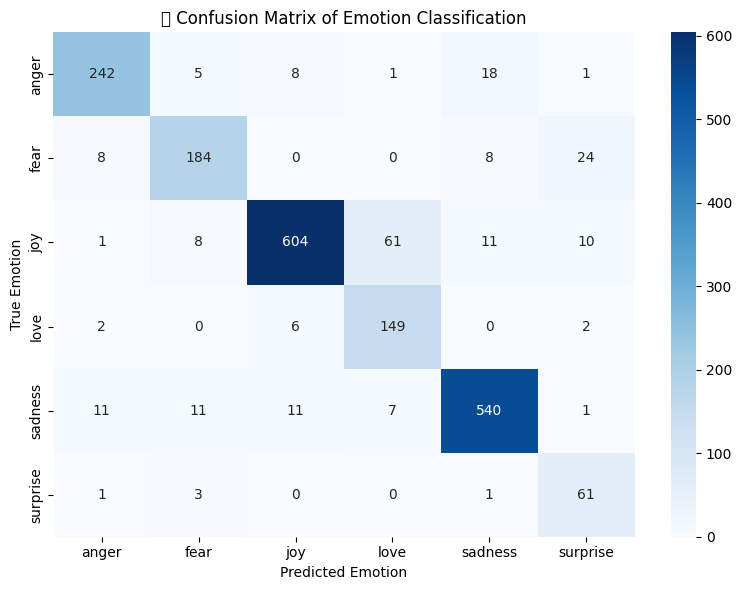

✅ Test Accuracy: 0.8900


In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict on test data
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 2: Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_classes))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('🔍 Confusion Matrix of Emotion Classification')
plt.tight_layout()
plt.show()

# Step 5: Print overall accuracy
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"✅ Test Accuracy: {accuracy:.4f}")
